In [ ]:
!pip install tensorflow-addons
!pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import library
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import random
import math
import cv2
import os
import warnings
import datetime
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import layers, models
from time import time
from focal_loss import BinaryFocalLoss
from keras.applications.efficientnet import preprocess_input

# Arsitektur CNN transfer learning yang dipakai

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet201

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class DatasetParser():
    def __init__(self, root_dir, images_dir, labels_csv, task_type="binary"):

        self.image_paths = sorted(glob.glob(os.path.join(root_dir, images_dir,"*.png")))
        self.labels_df = self._labels_by_task(task_type=task_type, root_dir=root_dir, labels_csv=labels_csv)
        self.task_type = task_type

        if task_type == "binary":
            self.labels = ['normal', 'abnormal']
        elif task_type == "percobaan1":
            self.labels = ['infiltrat','fibroinfiltrat','konsolidasi','kavitas','efusi_pleura','fibrosis','bronkiektasis', 'penebalan_pleura','atelektasis','limfadenopati','pneumothoraks','bullae','tuberkuloma','milier','normal']


    def visualize_random_images(self, num_images=1, label=None, display_label=False):

        fig = plt.figure(figsize=(20,20))
        fig.tight_layout(pad=10.0)
        if label is None:
            idxs = random.sample(range(len(self.image_paths)), num_images)
        else:
            idxs = [idx for idx in range(len(self.labels_df['Label'])) if label in self.labels_df['Label'][idx]]
            if len(idxs) < num_images:
                num_images = len(idxs)
            else:
                idxs = random.sample(idxs, num_images)

        num_rows = math.ceil(np.sqrt(num_images))
        num_cols = math.ceil(num_images/num_rows)

        for i in range(num_images):
            img = cv2.imread(self.image_paths[idxs[i]])
            plt.subplot(num_rows, num_cols, i+1)
            if display_label:
                plt.gca().set_title(self.labels_df['Label'][idxs[i]],wrap=True)
            plt.axis('off')
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    def _labels_by_task(self,task_type="binary", root_dir=None, labels_csv=None):


        labels_df = pd.read_csv(os.path.join(root_dir, labels_csv))
        new_labels_df = pd.DataFrame()
        new_labels_df['Id'] = labels_df['Image Index'].copy()

        if task_type == "binary":
            new_labels_df.loc[labels_df['Finding Labels'] == "No Finding",'Label'] = "normal"
            new_labels_df.loc[labels_df['Finding Labels'] != "No Finding", 'Label'] = "abnormal"
        else:
            new_labels_df['Label'] = labels_df['Finding Labels'].apply(lambda val: val.split('|'))

        del labels_df

        return new_labels_df

    def explore_class_imbalance(self):

        label_counts = [0 for i in range(len(self.labels))]

        for label in self.labels_df['Label']:
            if self.task_type == "binary":
                label_counts[self.labels.index(label)] += 1
            else:
                for element in label:
                    label_counts[self.labels.index(element)] += 1

        fig, ax1 = plt.subplots(1,1,figsize = (6, 6))
        ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
        ax1.set_xticks(np.arange(len(label_counts))+0.5)
        _ = ax1.set_xticklabels(self.labels, rotation = 90)

        for i,label in enumerate(self.labels):
            print(label, ':', label_counts[i])

        if(min(label_counts) < np.sqrt(max(label_counts))):
            print("Imbalance detected")
        else:
            print("Imbalance not detected")

    def get_labels_df(self):

        new_labels_df = self.labels_df.copy()

        if self.task_type == "binary":
            new_labels_df.loc[self.labels_df['Label'] == "normal",'Label'] = str(0)
            new_labels_df.loc[self.labels_df['Label'] != "normal", 'Label'] = str(1)
        else:
            for i in range(len(new_labels_df)):
                one_hot = [0 for element in self.labels]
                for element in new_labels_df['Label'][i]:
                    one_hot[self.labels.index(element)] = 1
                new_labels_df['Label'][i] = one_hot

        return new_labels_df

    def sample(self, num_samples, is_weighted=False):

        if not is_weighted:
            return self.labels_df.sample(num_samples)
        else:
            sample_weights = self.labels_df['Label'].map(lambda x: len(x)).values + 4e-2
            sample_weights /= sample_weights.sum()
            return self.labels_df.sample(num_samples, weights=sample_weights)

In [ ]:
'''
Parameter
'''
d_model = 768  #hidden size
d_ff = d_model * 2
n_heads = 12
mlp_head_size = 3072
dropout = 0.1
activation = 'relu'
n_layers = 12
patch_size = 1
batch_size = 4
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
accuracy = tf.keras.metrics.BinaryAccuracy(name="accuracy", dtype=None, threshold=0.5)
path = '/content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/HASIL MODEL'

DATA

In [ ]:
parser = DatasetParser(root_dir="/content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/DATA/",
                       images_dir="/content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/DATA/DATA_GABUNGAN(133 DATA)",
                       labels_csv="/content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/CSV/sample_labels.csv",
                       task_type="percobaan1"
                      )

In [ ]:
df = parser.sample(133, is_weighted=True)
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/CSV/train_1.csv')
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/CSV/val_1.csv')
val_id = val['Id'].values.tolist()
train_id = train['Id'].values.tolist()
val = df[df["Id"].isin(val_id)]
train = df[df["Id"].isin(train_id)]

In [ ]:
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

"""Creating train and val generator"""
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True,
                                   vertical_flip = False,
                                   height_shift_range= 0.05,
                                   width_shift_range=0.1,
                                   rotation_range=5,
                                   shear_range = 0.1,
                                   fill_mode = 'reflect',
                                   zoom_range=0.15)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='/content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/DATA/DATA_GABUNGAN(133 DATA)',
        x_col="Id",
        y_col="Label",
        batch_size=batch_size,
        target_size=(384,384),
        classes = parser.labels,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val,
        directory='/content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/DATA/DATA_GABUNGAN(133 DATA)',
        x_col="Id",
        y_col="Label",
        batch_size=batch_size,
        target_size=(384,384),
        classes = parser.labels,
        class_mode='categorical')

Found 106 validated image filenames belonging to 15 classes.
Found 27 validated image filenames belonging to 15 classes.


HYBRID MODEL

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

def point_wise_feed_forward_network(d_model, d_ff, activation):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(d_ff, activation=activation),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, depth, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = depth

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights


class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout, activation, **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.dropout = dropout
        self.activation = activation

        assert self.d_model % self.num_heads == 0, "d_model must be divisible by num_heads"

        self.depth = d_model // self.num_heads

        self.mha = MultiHeadAttention(self.d_model, self.num_heads, self.depth)

        self.ffn = point_wise_feed_forward_network(self.d_model, self.d_ff, self.activation)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(self.dropout)
        self.dropout2 = tf.keras.layers.Dropout(self.dropout)


    def call(self, x, training):
        attn_output, _ = self.mha(x, x, x, None)  # (batch_size, input_seq_len, d_model)

        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout, activation, n_layers, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.n_layers = n_layers
        self.encoder_layers = [TransformerEncoderLayer(d_model, num_heads,
                                                       d_ff, dropout, activation) for i in range(n_layers)]

    def get_config(self):
        config = {
            'n_layers': self.n_layers
        }

        base_config = super(TransformerEncoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x):
        for i in range(self.n_layers):
            x = self.encoder_layers[i](x)

        return x


class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size

    def get_config(self):
        config = {
            'patch_size': self.patch_size
        }

        base_config = super(Patches, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchClassEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model, n_patches, kernel_initializer='he_normal', **kwargs):
        super(PatchClassEmbedding, self).__init__(**kwargs)
        self.d_model = d_model
        self.n_tot_patches = n_patches + 1
        self.kernel_initializer = kernel_initializer
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.class_embed = self.add_weight(shape=(1, 1, self.d_model), initializer=self.kernel_initializer, name="class_token") # extra learnable class
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=(self.n_tot_patches), output_dim=self.d_model
        )

    def get_config(self):
        config = {
            'd_model': self.d_model,
            'n_tot_patches': self.n_tot_patches,
            'kernel_initializer': self.kernel_initializer
        }

        base_config = super(PatchClassEmbedding, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.n_tot_patches, delta=1)
        x =  tf.repeat(self.class_embed, tf.shape(inputs)[0], axis=0)
        x = tf.concat((x, inputs), axis=1)
        encoded = x + self.position_embedding(positions)
        return encoded

In [ ]:
backbone = EfficientNetV2L(input_shape=train_generator[0][0].shape[1:], include_top=False)

for layer in backbone.layers:
    layer.trainable = False

transformer = TransformerEncoder(d_model, n_heads, d_ff, dropout,
                                 activation, n_layers)

473176280/473176280 [==============================] - 21s 0us/step


In [ ]:
input_size = train_generator[0][0].shape[1:]

def Hybrid_CNN_ViT(backbone, transformer):
    # Input
    inputs = tf.keras.layers.Input(shape=input_size)

    x = inputs

    # Feed Backbne
    x = backbone(x)

    backbone_shape = x.shape

    # Patch Creation
    x = Patches(patch_size)(x)

    # Linear Projection of Flattened Patches
    x = tf.keras.layers.Dense(d_model)(x)

    # Position Embedding + Extra learnable class embedding
    n_patches = (backbone_shape[1]//patch_size)**2
    x = PatchClassEmbedding(d_model, n_patches)(x)

    # Transformer Model
    x = transformer(x)

    # Take only the Extra Learnable Class
    x = tf.keras.layers.Lambda(lambda x: x[:,0,:])(x)

    # MLP Head
    x = tf.keras.layers.Dense(mlp_head_size, activation= tf.keras.activations.gelu)(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(len(parser.labels), activation = 'sigmoid')(x)

    return tf.keras.models.Model(inputs, outputs)

In [ ]:
vit_model = Hybrid_CNN_ViT(backbone, transformer)
vit_model.compile(optimizer = opt, loss = BinaryFocalLoss(gamma=2),
                           metrics = [accuracy])
vit_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, 12, 12, 1280)     117746848 
 l)                                                              
                                                                 
 patches (Patches)           (None, None, 1280)        0         
                                                                 
 dense_72 (Dense)            (None, None, 768)         983808    
                                                                 
 patch_class_embedding (Patc  (None, 145, 768)         112128    
 hClassEmbedding)                                                
                                                                 
 transformer_encoder (Transf  (None, 145, 768)         567244

TRAIN THE MODEL

In [ ]:
csv_logger = tf.keras.callbacks.CSVLogger(path +'/Training-Logs_fix.csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint(path + '/Hybrid-best-model_fix.h5', verbose=1,
                                               monitor='accuracy', save_best_only=True, mode='auto')
callbacks = [
     EarlyStopping(patience=5, verbose=1), ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
     csv_logger,checkpoint
]

initial_epoch = 25
start = time()
train_steps = int(len(train)/batch_size)
val_steps = int(len(val)/batch_size)

history = vit_model.fit(train_generator,steps_per_epoch=train_steps,
                    epochs=initial_epoch,callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    verbose=1)
print("\n")
print("Waktu yang dibutuhkan = ", time()-start, "detik")
vit_model.save(path + '/fix.h5')

Epoch 1/25
26/26 [==============================] - ETA: 0s - loss: 3.0235 - accuracy: 0.8124
Epoch 1: accuracy improved from -inf to 0.81242, saving model to /content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/HASIL MODEL/Hybrid-best-model_fix.h5
26/26 [==============================] - 274s 11s/step - loss: 3.0235 - accuracy: 0.8124 - val_loss: 3.3132 - val_accuracy: 0.7944 - lr: 0.0100
Epoch 2/25
26/26 [==============================] - ETA: 0s - loss: 2.9813 - accuracy: 0.8150
Epoch 2: accuracy improved from 0.81242 to 0.81503, saving model to /content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/HASIL MODEL/Hybrid-best-model_fix.h5
26/26 [==============================] - 308s 12s/step - loss: 2.9813 - accuracy: 0.8150 - val_loss: 3.2684 - val_accuracy: 0.7972 - lr: 0.0100
Epoch 3/25
26/26 [==============================] - ETA: 0s - loss: 3.0024 - accuracy: 0.8137
Epoch 3: accuracy did not improve from 0.81503
26/26 [==============================] - 275s 11s/step -

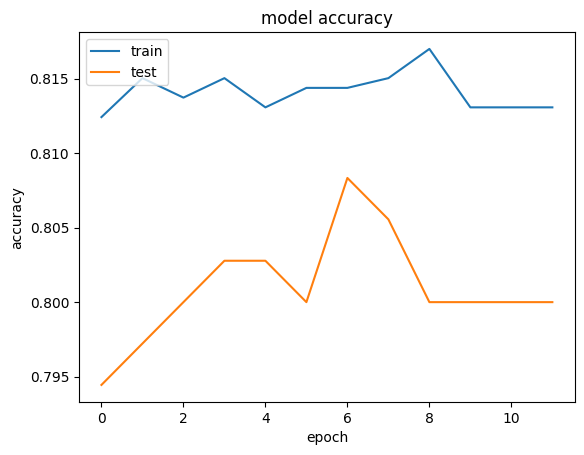

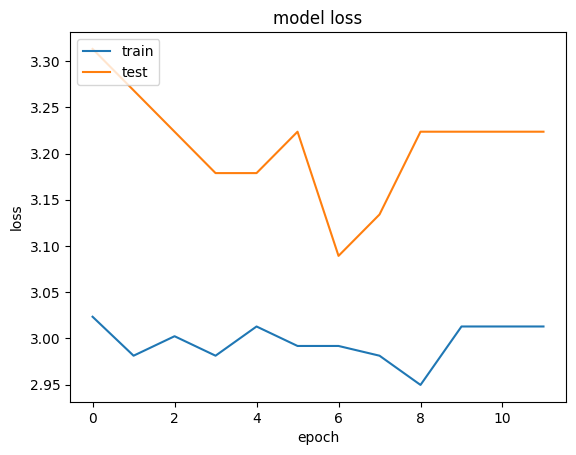

In [ ]:
history = vit_model.history

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

ASL LOSS

In [ ]:
!pip install torch>=1.7
!pip install torchvision>=0.5.0
#git+https://github.com/mapillary/inplace_abn.git@v1.0.12
!pip install randaugment
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


class ASLSingleLabel(nn.Module):
    '''
    This loss is intended for single-label classification problems
    '''
    def __init__(self, gamma_pos=0, gamma_neg=4, eps: float = 0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target):
        '''
        "input" dimensions: - (batch_size,number_classes)
        "target" dimensions: - (batch_size)
        '''
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes = self.targets_classes.mul(1 - self.eps).add(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [ ]:
"""Implements asymmetric loss."""

from typing import Optional
import tensorflow as tf
from typeguard import typechecked

@tf.keras.utils.register_keras_serializable(package="Addons")
class SigmoidAsymmetricLoss(tf.keras.losses.Loss):
    """
    Implements the asymmetric loss function.
    (https://arxiv.org/pdf/2009.14119.pdf).
    This is the first one among the three versions of the loss:
    AsymmetricLoss, AsymmetricLossOptimized, ASLSingleLabel
    (https://github.com/Alibaba-MIIL/ASL/blob/main/src/loss_functions/losses.py)
    Usage with `tf.keras` API:
    >>> model = tf.keras.Model()
    >>> model.compile(optimizer='sgd', loss=SigmoidAsymmetricLoss())
    """
    @typechecked
    def __init__(
        self,
        from_logits: bool = False,
        gamma_neg: float = 4.0,
        gamma_pos: float = 1.0,
        clip: float = 0.05,
        epsilon: float = 1e-8,
        reduction: str = tf.keras.losses.Reduction.NONE,
        name: Optional[str] = None,
    ):
        super().__init__(name=name, reduction=reduction)
        self.from_logits = from_logits
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.epsilon = epsilon or tf.keras.backend.epsilon()

    def call(self, y_true, y_pred):
        # Set Data Types
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, dtype=y_pred.dtype)

        # Calculating Probabilities
        if self.from_logits:
            y_pred = tf.sigmoid(y_pred)
        xs_pos = y_pred
        xs_neg = 1.0 - y_pred

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = xs_neg + self.clip
            xs_neg = tf.clip_by_value(xs_neg, clip_value_min=tf.reduce_min(xs_neg), clip_value_max=1.0)

        # Basic CE calculation
        xs_pos = tf.clip_by_value(xs_pos, clip_value_min=self.epsilon, clip_value_max=tf.reduce_max(xs_pos))
        xs_neg = tf.clip_by_value(xs_neg, clip_value_min=self.epsilon, clip_value_max=tf.reduce_max(xs_neg))
        los_pos = y_true * tf.math.log(xs_pos)
        los_neg = (1.0 - y_true) * tf.math.log(xs_neg)
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt0 = xs_pos * y_true
            pt1 = xs_neg * (1.0 - y_true) # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y_true + self.gamma_neg * (1.0 - y_true)
            one_sided_w = tf.math.pow(1.0 - pt, one_sided_gamma)
            loss *= one_sided_w

        return -tf.math.reduce_sum(loss, axis=-1)

    def get_config(self):
        config = {
            "from_logits": self.from_logits,
            "gamma_neg": self.gamma_neg,
            "gamma_pos": self.gamma_pos,
            "clip": self.clip,
            "epsilon": self.epsilon,
        }
        base_config = super().get_config()
        return {**base_config, **config}

In [ ]:
#criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
#loss = criterion(output, target)

vit_model = Hybrid_CNN_ViT(backbone, transformer)
vit_model.compile(optimizer = opt, loss = SigmoidAsymmetricLoss(),metrics = [accuracy])
vit_model.summary()


'''
def custom_loss(y_pred, y_true):
    alpha = 2.0
    loss = (y_pred - y_true) ** 2.0
    adj = tf.math.multiply(y_pred,y_true)
    adj = tf.where(tf.greater(adj, 0.0), tf.constant(1/alpha), adj)
    adj = tf.where(tf.less(adj, 0.0), tf.constant(alpha), adj)
    loss = loss * adj
    return  tf.reduce_mean(loss)


model.compile(optimizer='adam', loss=custom_loss)
model.fit(x, y, epochs=200, batch_size=16)
'''


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, 12, 12, 1280)     117746848 
 l)                                                              
                                                                 
 patches_6 (Patches)         (None, None, 1280)        0         
                                                                 
 dense_90 (Dense)            (None, None, 768)         983808    
                                                                 
 patch_class_embedding_6 (Pa  (None, 145, 768)         112128    
 tchClassEmbedding)                                              
                                                                 
 transformer_encoder (Transf  (None, 145, 768)         5672

"\ndef custom_loss(y_pred, y_true):\n    alpha = 2.0\n    loss = (y_pred - y_true) ** 2.0\n    adj = tf.math.multiply(y_pred,y_true)\n    adj = tf.where(tf.greater(adj, 0.0), tf.constant(1/alpha), adj)\n    adj = tf.where(tf.less(adj, 0.0), tf.constant(alpha), adj)\n    loss = loss * adj\n    return  tf.reduce_mean(loss)\n\n\nmodel.compile(optimizer='adam', loss=custom_loss)\nmodel.fit(x, y, epochs=200, batch_size=16)\n"

In [ ]:
csv_logger = tf.keras.callbacks.CSVLogger(path +'/Training-Logs_ASL.csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint(path + '/Hybrid-best-model_ASL.h5', verbose=1,
                                               monitor='accuracy', save_best_only=True, mode='auto')
callbacks = [
     EarlyStopping(patience=5, verbose=1), ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
     csv_logger,checkpoint
]

initial_epoch = 25
start = time()
train_steps = int(len(train)/batch_size)
val_steps = int(len(val)/batch_size)

history = vit_model.fit(train_generator,steps_per_epoch=train_steps,
                    epochs=initial_epoch,callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    verbose=1)
print("\n")
print("Waktu yang dibutuhkan = ", time()-start, "detik")
vit_model.save(path + '/fix.h5')

Epoch 1/25
26/26 [==============================] - ETA: 0s - loss: 36.5048 - accuracy: 0.4065 
Epoch 1: accuracy improved from -inf to 0.40654, saving model to /content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/HASIL MODEL/Hybrid-best-model_ASL.h5
26/26 [==============================] - 517s 17s/step - loss: 36.5048 - accuracy: 0.4065 - val_loss: 41.1787 - val_accuracy: 0.4389 - lr: 0.0100
Epoch 2/25
26/26 [==============================] - ETA: 0s - loss: 37.1268 - accuracy: 0.4490 
Epoch 2: accuracy improved from 0.40654 to 0.44902, saving model to /content/drive/MyDrive/Colab Notebooks/SKRIPSI_Stef/SKRIPSI/HASIL MODEL/Hybrid-best-model_ASL.h5
26/26 [==============================] - 465s 18s/step - loss: 37.1268 - accuracy: 0.4490 - val_loss: 40.1062 - val_accuracy: 0.4500 - lr: 0.0100
Epoch 3/25
26/26 [==============================] - ETA: 0s - loss: 37.2784 - accuracy: 0.4458 
Epoch 3: accuracy did not improve from 0.44902
26/26 [==============================] - 421s 

In [ ]:
!git clone https://github.com/IMvision12/NextViT-tf


Cloning into 'NextViT-tf'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 133 (delta 64), reused 81 (delta 25), pack-reused 0
Receiving objects: 100% (133/133), 402.91 KiB | 4.97 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/bin/bash: line 0: cd: nextvit_tf: No such file or directory


In [ ]:
%cd NextViT-tf

/content/NextViT-tf


In [ ]:
!pip install --force einops==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached einops-0.4.1-py3-none-any.whl (28 kB)
  Attempting uninstall: einops
    Found existing installation: einops 0.4.1
    Uninstalling einops-0.4.1:
      Successfully uninstalled einops-0.4.1


In [ ]:
import tensorflow as tf
from models.nextvit_tf import nextvit_base

model = nextvit_base(input_shape=(384, 384, 3), num_classes=15)
#print(model.summary(expand_nested=True))
model.compile(optimizer = opt, loss = BinaryFocalLoss(gamma=2),metrics = [accuracy])
model.fit(train_generator, epochs=25, validation_data=validation_generator)

In [ ]:
csv_logger = tf.keras.callbacks.CSVLogger(path +'/Training-Logs_nextvit_focal.csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint(path + '/nextvit_focal.h5', verbose=1,
                                               monitor='accuracy', save_best_only=True, mode='auto')
callbacks = [
     EarlyStopping(patience=5, verbose=1), ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
     csv_logger,checkpoint
]

initial_epoch = 25
start = time()
train_steps = int(len(train)/batch_size)
val_steps = int(len(val)/batch_size)

history = model.fit(train_generator,steps_per_epoch=train_steps,
                    epochs=initial_epoch,callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    verbose=1)
print("\n")
print("Waktu yang dibutuhkan = ", time()-start, "detik")
model.save(path + '/nextvit_focal.h5')